In [24]:
import torch 
import torch.nn as nn 
import torchvision 
from torchvision import transforms, datasets 
from torch.utils.data import DataLoader, random_split 
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image 
import os

In [25]:
BATCH_SIZE = 32 
IMAGE_SIZE = 256 
CHANNELS = 3
EPOCHS = 50

In [26]:
basic_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize to 256x256.
    transforms.ToTensor() # Convert PIL Image to tensor and scale to [0,1].
])

In [27]:
dataset = datasets.ImageFolder(
    root="PlantVillage",
    transform=basic_transform
)

print(f"Found {len(dataset)} images belonging to {len(dataset.classes)} classes.")
class_names = dataset.classes 
print(f"Classes: {class_names}")

Found 4500 images belonging to 3 classes.
Classes: ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


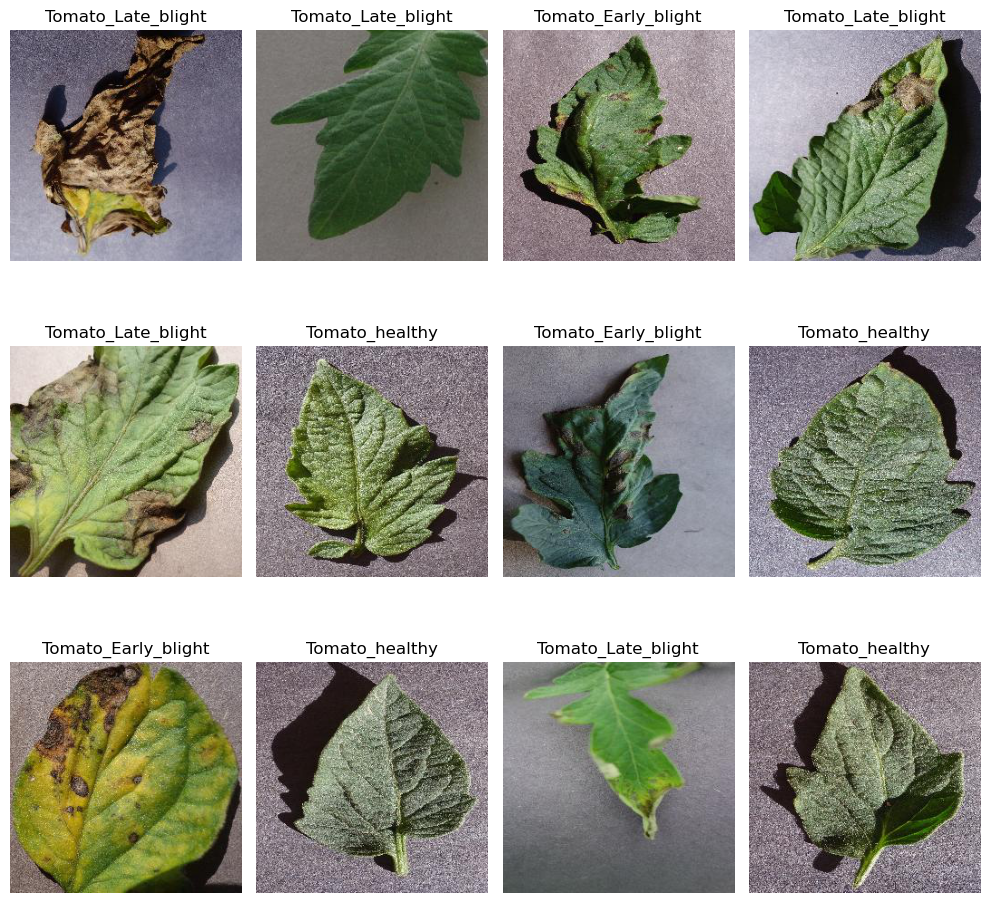

In [28]:
def visualise_dataset(dataset, class_names, num_images=12):
    temp_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(temp_loader))

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # PyTorch uses CHW but Matplotlib expects HWC,
        # so we change the order.
        img = images[i].permute(1, 2, 0).numpy() 

        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualise_dataset(dataset, class_names)

In [29]:
def get_dataset_partitions_pytorch(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = len(dataset)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size 

    print(f"Dataset split-------")
    print(f"Total samples: {dataset_size}")
    print(f"Training samples: {train_size}")
    print(f"Validation samples: {val_size}")
    print(f"Test samples: {test_size}")

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, 
        [train_size, val_size, test_size],
        generator = torch.Generator().manual_seed(17)
    )

    return train_dataset, val_dataset, test_dataset

In [30]:
# Augmentation to get more varied training samples 
# so our model can be more robust.
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor()
])

# Just basic preprocessing for val and test, no augmentation needed.
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [31]:
train_dataset_augmented = datasets.ImageFolder(
    root="PlantVillage",
    transform=train_transform
)

val_test_dataset = datasets.ImageFolder(
    root="PlantVillage",
    transform=val_test_transform
)

# Split the augmented training dataset and non-augmented val and test dataset
train_dataset_aug, _, _ = get_dataset_partitions_pytorch(train_dataset_augmented)
_, val_dataset_clean, test_dataset_clean = get_dataset_partitions_pytorch(val_test_dataset)

Dataset split-------
Total samples: 4500
Training samples: 3600
Validation samples: 450
Test samples: 450
Dataset split-------
Total samples: 4500
Training samples: 3600
Validation samples: 450
Test samples: 450


In [32]:
train_loader = DataLoader(
    train_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset_clean,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset_clean,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 113
Number of validation batches: 15
Number of test batches: 15


In [33]:
for images, labels in train_loader:
    print(f"Training batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
    print(f"Sample labels: {labels[:10].numpy()}")
    break

for images, labels in val_loader:
    print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Training batch - Images shape: torch.Size([32, 3, 256, 256]), Labels shape: torch.Size([32])
Sample labels: [1 2 2 1 2 0 2 0 2 2]
Validation batch - Images shape: torch.Size([32, 3, 256, 256]), Labels shape: torch.Size([32])


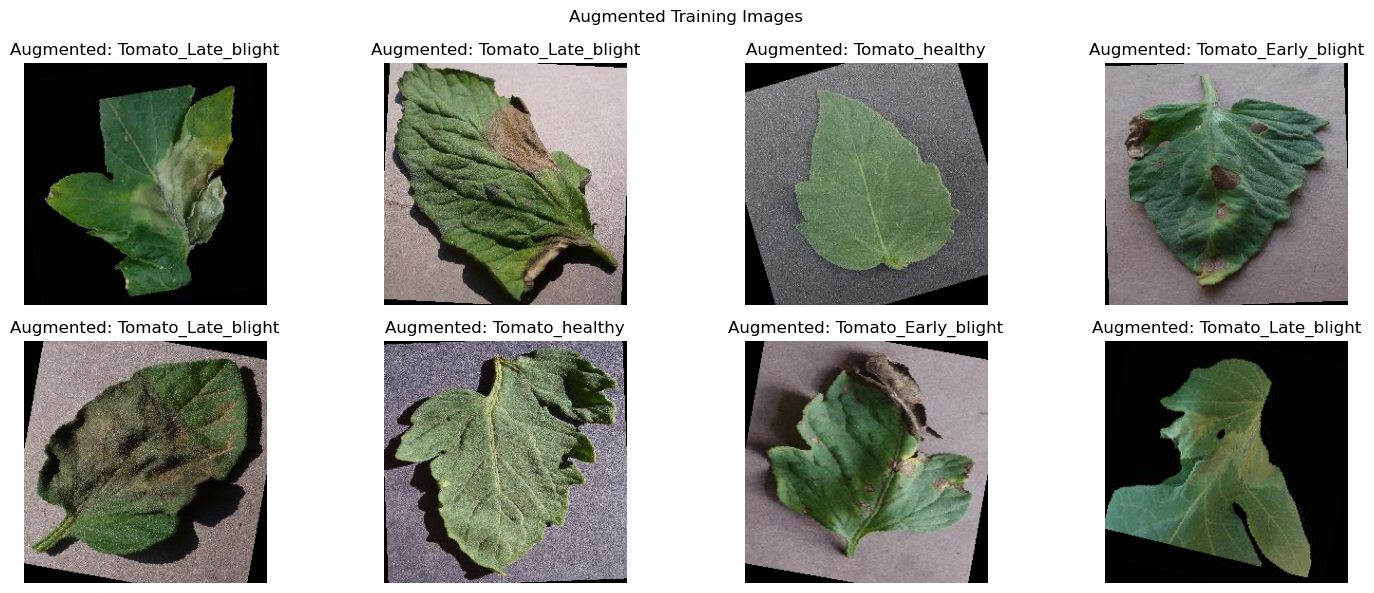

In [34]:
def visualise_augmentation(dataset, class_names, num_images=8):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    
    plt.figure(figsize=(15, 6))
    for i in range(min(num_images, 8)):
        ax1 = plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Augmented: {class_names[labels[i]]}")
        plt.axis("off")
    
    plt.suptitle("Augmented Training Images")
    plt.tight_layout()
    plt.show()

visualise_augmentation(train_dataset_aug, class_names)